In [ ]:
import numpy as np
import scipy as sc
import matplotlib as mpl
import matplotlib.pyplot as plt
from uncertainties import unumpy as unp
from uncertainties import ufloat, umath
from glob import glob
import tifffile
from options import *
from constants import *

nom_vals = unp.nominal_values
std_devs = unp.std_devs

mpl.rcParams.update(rcParams)


In [2]:
wavelengths = [647, 561, 488]  # nm

In [3]:
def gaussian_2D(xy, amplitude, offset, mu_x, mu_y, sigma):
    x, y = xy
    res = amplitude * np.exp(-((x - mu_x)**2 + (y - mu_y)**2) / (2 * sigma**2)) + offset
    return np.ravel(res)

In [4]:
def read_img(path: str) -> np.ndarray:
    imdata = tifffile.imread(path)
    pix_min = np.min(imdata, axis=(1,2))
    pix_max = np.max(imdata, axis=(1,2))
    normalized_imdata = (imdata - pix_min[:, np.newaxis, np.newaxis]) / (pix_max - pix_min)[:, np.newaxis, np.newaxis]
    return normalized_imdata

In [5]:
def do_fit(selection):
    XX = np.arange(selection.shape[0])
    YY = np.arange(selection.shape[1])
    XY = np.meshgrid(XX, YY)
    popt, pcov = sc.optimize.curve_fit(
        gaussian_2D,
        XY, selection.flatten(),
        p0=(1, 0, selection.shape[0] / 2, selection.shape[1] / 2, 1),
        bounds=(0, np.inf)
    )
    return popt, pcov

In [6]:
imdata_647nm = read_img('../data/beads/Acquisition-1/ROI.tif')
imdata_561nm = read_img('../data/beads/Acquisition-2/ROI.tif')
imdata_488nm = read_img('../data/beads/Acquisition-3/ROI.tif')
all_imdata = [imdata_647nm, imdata_561nm, imdata_488nm]

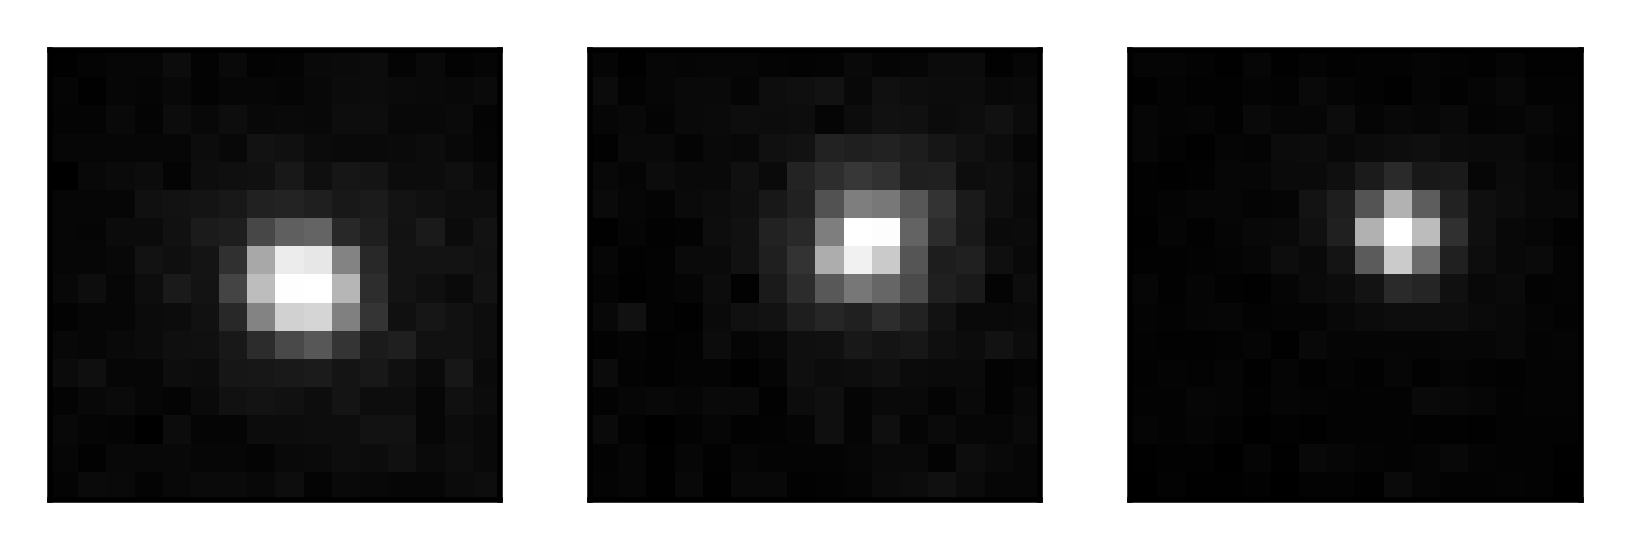

In [7]:
bead_sel = [slice(138, 154), slice(208, 224)]
fig, ax = plt.subplots(ncols=3, dpi=500)
for i in range(3):
    ax[i].imshow(all_imdata[i][0, *bead_sel], cmap=plt.get_cmap('Greys_r'), rasterized=True)
    ax[i].grid(False)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.savefig("../figures/beads_drifting.pdf")

In [8]:
mu_xs = [np.zeros(imdata.shape[0]) for imdata in all_imdata]
mu_ys = [np.zeros(imdata.shape[0]) for imdata in all_imdata]
sigmas = [np.zeros(imdata.shape[0]) for imdata in all_imdata]

for i, (wavelength, imdata) in enumerate(zip(wavelengths, all_imdata)):
    for j, layer in enumerate(imdata):
        popt, pcov = do_fit(layer[*bead_sel])
        mu_xs[i][j] = popt[2]
        mu_ys[i][j] = popt[3]
        sigmas[i][j] = popt[4]

### Show the stuff

In [9]:
p = plt.rcParams
p['savefig.bbox'] = 'standard'
p["figure.figsize"] = (8*INCH_PER_CM, 7*INCH_PER_CM) # a bit less than half \textwidth
p["figure.subplot.left"]   = 0.17
p['figure.subplot.right']  = 0.97
p['figure.subplot.top']    = 0.97
p['figure.subplot.bottom'] = 0.18

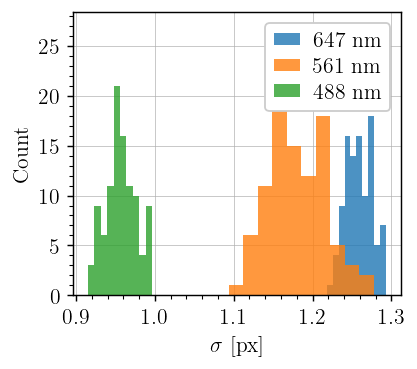

In [15]:
plt.hist(sigmas[0], alpha=0.8,
        label=fr"{wavelengths[0]} nm")
plt.hist(sigmas[1], alpha=0.8,
        label=fr"{wavelengths[1]} nm")
plt.hist(sigmas[2], alpha=0.8,
        label=fr"{wavelengths[2]} nm")
plt.xlabel(r"$\sigma$ [px]")
plt.ylabel(r"Count")

plt.legend()
plt.savefig("../figures/comparison_sigma.pdf")

### x and y

In [11]:
def scatter_hist(x, y, ax, ax_histx, ax_histy, label):
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax.scatter(x, y, marker='.', s=2, label=label)

    ax_histx.hist(x)
    ax_histy.hist(y, orientation='horizontal')


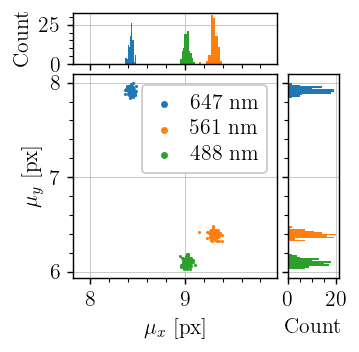

In [26]:
p['savefig.bbox'] = 'standard'
p["figure.subplot.left"]   = 0.2
p['figure.subplot.right']  = 1
p['figure.subplot.top']    = 1.2
p['figure.subplot.bottom'] = 0.18

fig = plt.figure()

ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(mu_xs[0], mu_ys[0], ax, ax_histx, ax_histy,
            label=fr"{wavelengths[0]} nm")
scatter_hist(mu_xs[1], mu_ys[1], ax, ax_histx, ax_histy,
            label=fr"{wavelengths[1]} nm")
scatter_hist(mu_xs[2], mu_ys[2], ax, ax_histx, ax_histy,
            label=fr"{wavelengths[2]} nm")

ax.set_xlabel(r"$\mu_x$ [px]")
ax.set_ylabel(r"$\mu_y$ [px]")
ax_histx.set_ylabel('Count')
ax_histy.set_xlabel('Count')

# blegh
plt.axis('square')
xlims = ax.get_xlim()
ax.set_xlim(xlims[0] - 0.5, xlims[1] - 0.5)

plt.legend(markerscale=4)
plt.savefig("../figures/comparison_mu.pdf")

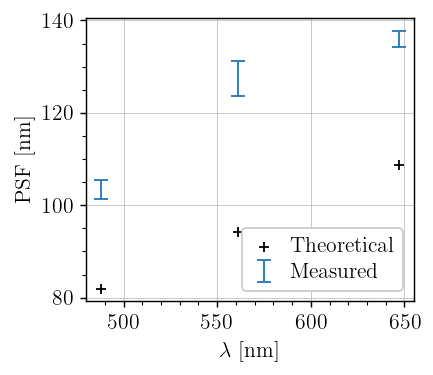

In [13]:
NM_PER_PX = 108  # nm
psf_widths = unp.uarray(
    list(map(lambda s: np.mean(s * NM_PER_PX), sigmas)),
    list(map(lambda s: np.std(s * NM_PER_PX), sigmas))
)
plt.errorbar(wavelengths, nom_vals(psf_widths), yerr=std_devs(psf_widths), ls='', label='Measured')
# TODO: VERIFY FORMULA
plt.scatter(wavelengths, list(map(lambda l: 0.21 * l / NUMERICAL_APERTURE, wavelengths)), color='k', label='Theoretical')
plt.xlabel(r'$\lambda$ [nm]')
plt.ylabel(r'PSF [nm]')
plt.legend()

plt.savefig("../figures/comparison_PSF.pdf")

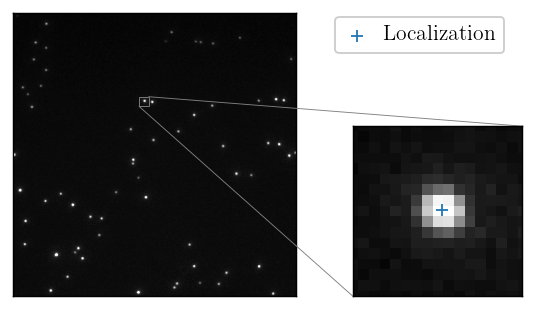

In [14]:
with mpl.rc_context():
    mpl.rcParams['axes.grid'] = False
    mpl.rcParams['xtick.bottom'] = False
    mpl.rcParams['xtick.labelbottom'] = False
    mpl.rcParams['ytick.left'] = False
    mpl.rcParams['ytick.labelleft'] = False

    mpl.rcParams['savefig.bbox'] = 'tight'
    # fig, ax = plt.subplots(1,1, figsize=(14*INCH_PER_CM, 7*INCH_PER_CM))
    fig, ax = plt.subplots()
    ax.set_xticks([])
    ax.set_yticks([])

    mu_xs_647nm = mu_xs[0]
    mu_ys_647nm = mu_ys[0]

    plt.imshow(imdata_647nm[0,:,:], cmap='Greys_r',
            vmax=0.4)

    axins = ax.inset_axes([1,0,1,0.6], xlim=(bead_sel[1].start,bead_sel[1].stop), ylim=(bead_sel[0].start, bead_sel[0].stop), alpha=0.5)
    rect, connection_lines = ax.indicate_inset_zoom(axins, edgecolor="grey", alpha=1, lw=0.5)
    plt.setp(connection_lines, lw=0.5)
    # connection_lines[0].set_visible(True)
    # connection_lines[1].set_visible(True)
    # connection_lines[2].set_visible(True)
    # connection_lines[3].set_visible(True)
    axins.set_xticks([])
    axins.set_yticks([])

    axins.invert_yaxis()
    axins.imshow(imdata_647nm[0], cmap=plt.get_cmap('Greys_r'),
                vmax=0.4)
    axins.scatter(np.mean(mu_xs_647nm+bead_sel[1].start), np.mean(mu_ys_647nm+bead_sel[0].start), marker='+', s=40,
                label='Localization')

    handles, labels = axins.get_legend_handles_labels()

    fig.legend(handles=handles, labels=labels, bbox_to_anchor=(1.45, 0.99))
    plt.savefig("../figures/beads_inset_zoom.pdf")
    plt.show()